# Running Process

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load Image

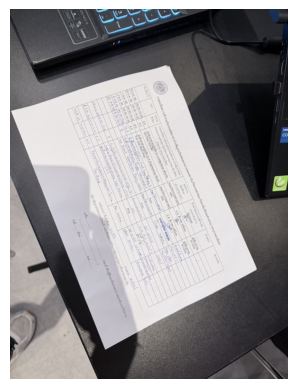

In [15]:
path = "document/S__225214471.jpg"
img = cv2.imread(path)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb);
plt.axis('off');

## Convert to Grayscale

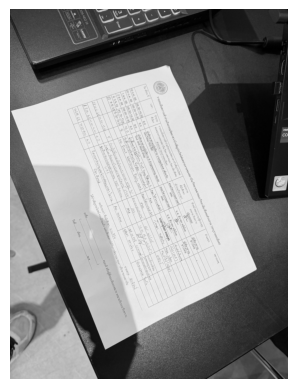

In [16]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray');
plt.axis('off');

## Method 1: Gaussian Filter + Canny

In [17]:
# Gaussian Filter
ks = 5
sigma = 1.0
kerX = cv2.getGaussianKernel(ks, sigma)
kerY = cv2.transpose(kerX)
ker_gau = kerX * kerY
blurred1 = cv2.filter2D(gray, cv2.CV_8U, ker_gau)

# Canny
edges1 = cv2.Canny(blurred1, 50, 150)

## Method 2: Gaussian + Morphology + Canny

In [18]:
# Gaussian Filter
ks = 5
sigma = 1.0
kerX = cv2.getGaussianKernel(ks, sigma)
kerY = cv2.transpose(kerX)
ker_gau = kerX * kerY
blurred2 = cv2.filter2D(gray, cv2.CV_8U, ker_gau)

# Strong morphology to suppress grid texture
kernel_big = cv2.getStructuringElement(cv2.MORPH_RECT, (25,25))
closed = cv2.morphologyEx(blurred2, cv2.MORPH_CLOSE, kernel_big, iterations=1)

# Canny
edges2 = cv2.Canny(closed, 50, 150)

## Find Contours for Both Methods

In [19]:
# Dilate (for clearer edge)
kernel = np.ones((3,3), np.uint8)
edges1_dilate = cv2.dilate(edges1, kernel, iterations=1)
edges1_dilate = cv2.morphologyEx(edges1_dilate, cv2.MORPH_CLOSE, kernel, iterations=1)

edges2_dilate = cv2.dilate(edges2, kernel, iterations=1)
edges2_dilate = cv2.morphologyEx(edges2_dilate, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours - Method 1
cnts1, _ = cv2.findContours(edges1_dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts1 = sorted(cnts1, key=cv2.contourArea, reverse=True)

doc1 = None
area1 = 0
for c in cnts1[:15]:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        doc1 = approx
        area1 = cv2.contourArea(approx)
        break

# Find contours - Method 2
cnts2, _ = cv2.findContours(edges2_dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts2 = sorted(cnts2, key=cv2.contourArea, reverse=True)

doc2 = None
area2 = 0
for c in cnts2[:15]:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        doc2 = approx
        area2 = cv2.contourArea(approx)
        break

print("Method 1 (Gaussian) area:", area1)
print("Method 2 (Morphology) area:", area2)

Method 1 (Gaussian) area: 627592.5
Method 2 (Morphology) area: 0


## Select Best Method (Largest Area)

In [20]:
if area1 > area2:
    doc = doc1
    print("Using Method 1: Gaussian")
else:
    doc = doc2
    print("Using Method 2: Morphology")

print("Document found:", doc is not None)

Using Method 1: Gaussian
Document found: True


## Show Detection

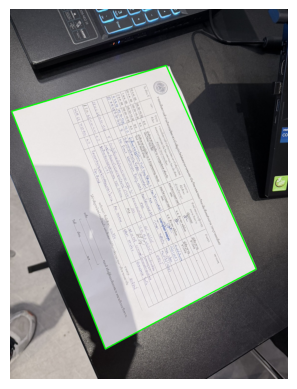

In [21]:
vis = rgb.copy()
if doc is not None:
    cv2.drawContours(vis, [doc], -1, (0,255,0), 3)

plt.imshow(vis);
plt.axis('off');

## Perspective Transform

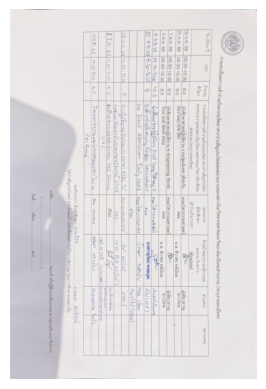

In [22]:
# Find 4 points
pts = doc.reshape(4, 2).astype("float32")

rect = np.zeros((4,2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]  # top-left
rect[2] = pts[np.argmax(s)]  # bottom-right

diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]  # top-right
rect[3] = pts[np.argmax(diff)]  # bottom-left

(tl, tr, br, bl) = rect

# Compute width and height of new image
widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))

heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))

dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]
], dtype="float32")

# Perspective Transform
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB));
plt.axis("off");

## Convert to Grayscale

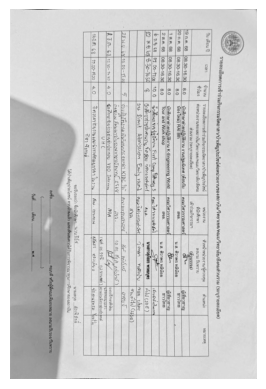

In [23]:
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

plt.imshow(warped_gray, cmap="gray");
plt.axis("off");

## Illumination Normalization (Shadow Removal)

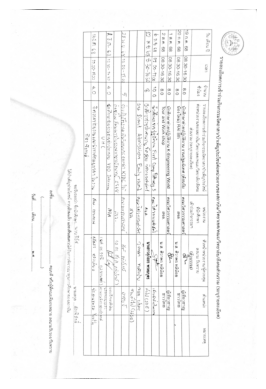

In [24]:
bg = cv2.GaussianBlur(warped_gray, (55,55), 0)
normalized = cv2.divide(warped_gray, bg, scale=255)

plt.imshow(normalized, cmap="gray");
plt.axis("off");

## Convert to Binary (Clean Scan)

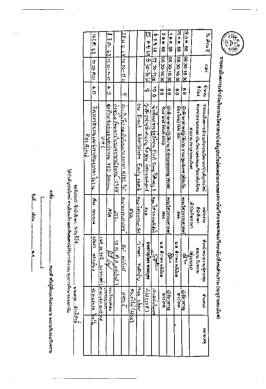

In [25]:
binary = cv2.adaptiveThreshold(
    normalized,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    25,
    10
)

plt.imshow(binary, cmap="gray");
plt.axis("off");